[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cadCAD-org/demos/blob/master/tutorials/robots_and_marbles/robot-marbles-part-2/robot-marbles-part-2.ipynb)

# cadCAD Tutorials: The Robot and the Marbles, part 2
In [Part 1](../robot-marbles-part-1/robot-marbles-part-1.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters

This article will introduce the concept of __Policies__. But first let's copy the base configuration from Part 1. As a reminder, here's the description of the simple system we are using for illustration purposes.

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and a robot arm capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robot is programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.  

In [1]:
%%capture
# Only run this cell if you need to install the libraries
# If running in google colab, this is needed.

!pip install cadcad matplotlib pandas numpy

In [2]:
# Import dependancies

# Data processing and plotting libraries
import pandas as pd
import numpy as np
from random import normalvariate
import matplotlib.pyplot as plt

# cadCAD specific libraries
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext, Executor

In [3]:
initial_state = {
    'box_A': 10, # box_A starts out with 10 marbles in it
    'box_B': 0 # box_B starts out empty
}

In [4]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
           
    box_A_new = box_a + b_to_a
    
    # Output
    return ('box_A', box_A_new)


def s_box_B(params, substep, state_history, previous_state, policy_input):
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
          
    box_B_new = box_b - b_to_a
  
    # Output
    return ('box_B', box_B_new)

In [5]:
partial_state_update_blocks = [
    { 
        'label': 'Marble Update',
        'policies': { # We'll ignore policies for now
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [6]:
MONTE_CARLO_RUNS = 1
SIMULATION_TIMESTEPS = 10

sim_config = config_sim(
    {
        'N': MONTE_CARLO_RUNS,
        'T': range(SIMULATION_TIMESTEPS),
        #'M': {} # This will be explained in later tutorials
    }
)

In [7]:
from cadCAD import configs
del configs[:]

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 10, 0, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 1, 2)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/11 [00:00<?, ?it/s]

Total execution time: 0.03s


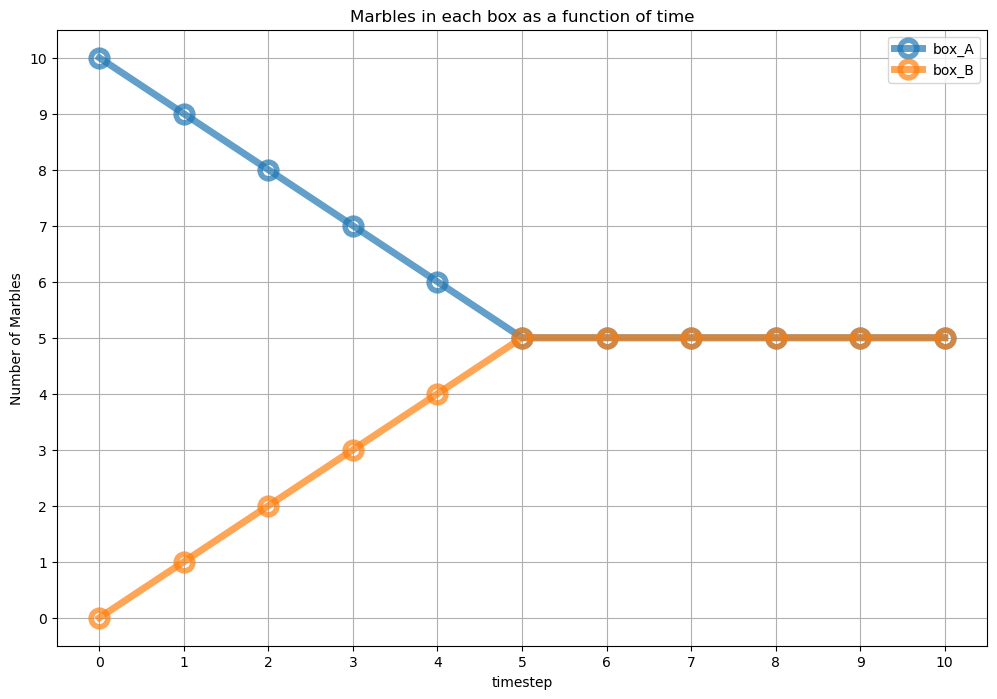

In [8]:
df = pd.DataFrame(system_events)
# Create figure
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

# Policies
In part 1, we ignored the `policy_input` argument of state update functions. That argument is a signal passed to the state update function by another set of functions: Policy Functions.

Policy Functions are most commonly used as representations of the behavior of agents that interact with the components of the system we're simulating in cadCAD. But more generally, they describe the logic of some component or mechanism of the system. It is possible to encode the functionality of a policy function in the state update functions themselves (as we did in part 1, where we had the robot's algorithm reside in the `s_box_A` and `s_box_B` functions), but as systems grow more complex this approach makes the code harder to read and maintain, and in some cases more inefficient because of unnecessary repetition of computational steps.

The general structure of a policy function is:
```python
def p_function(params, substep, state_history, previous_state):
    ...
    return {'value1': value1, 'value2': value2, ...}
```
Just like State Update Functions, policies can read the current state of the system from argument `previous_state`, a Python `dict` where the `dict_keys` are the __names of the variables__ and the `dict_values` are their __current values__. The Policy Function must return a dictionary, which will be passed as an argument (`policy_input`) to the state update functions.

![Policy](policy.png "Policy")

Let's update our simulation so that the robot arm's logic is encoded in a Policy instead of in the State Update Functions.

In [9]:
def p_robot_arm(params, substep, state_history, previous_state):
    
    # Parameters & variables
    box_a = previous_state['box_A']
    box_b = previous_state['box_B']
    
    # Logic
    if box_b > box_a:
        b_to_a = 1
    elif box_b < box_a:
        b_to_a = -1
    else:
        b_to_a = 0
    
    # Output
    return({'add_to_A': b_to_a, 'add_to_B': -b_to_a})

We make the state update functions less "intelligent", ie. they simply add the respective number of marbles specified in `policy_input` (which, per the policy function definition, may be negative)

In [10]:
def s_box_A(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_A_current = previous_state['box_A']
    box_A_change = policy_input['add_to_A']
   
    # Logic
    box_A_new = box_A_current + box_A_change
    
    # Output
    return ('box_A', box_A_new)
    
def s_box_B(params, substep, state_history,  previous_state, policy_input):
    # Parameters & variables
    box_B_current = previous_state['box_B']
    box_B_change = policy_input['add_to_B']

    # Logic
    box_B_new = box_B_current + box_B_change
    
    # Output
    return ('box_B', box_B_new)

In the __Partial State Update Blocks__, the user specifies if state update functions will be run in series or in parallel and the policy functions that will be evaluated in that block. In this case, the states are updated in parallel.

In [11]:
partial_state_update_blocks = [
    {
        'policies': {
            'robot_arm': p_robot_arm
        },
        'variables': {
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

The configurations above are then packaged into a `Configuration` object.

In [12]:
del configs[:]  # Clear any prior configs

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 10, 0, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 1, 2)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/11 [00:00<?, ?it/s]

Total execution time: 0.02s


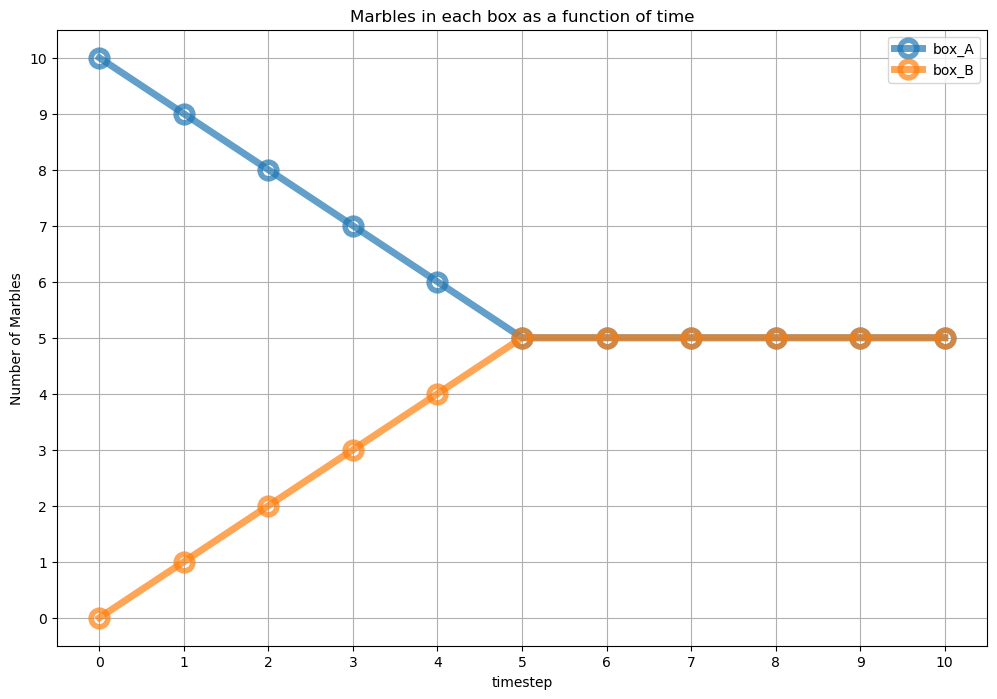

In [13]:
# Create figure
df = pd.DataFrame(system_events)
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

As expected, the results are the same as when the robot arm logic was encoded within the state update functions.  

## Policy Signal Aggregation

Several policies may be evaluated within a Partial State Update Block. When that's the case, cadCAD's engine aggregates the outputs of the policies and passes them as a single signal to the state update functions. 
![Policies](policies.png "Policies")

Aggregation of policies is defined in cadCAD as __key-wise sum (+) of the elements of the outputted `dict`s__.
```python
policy_1_output = {'int': 1, 'str': 'abc', 'list': [1, 2], '1-only': 'Specific to policy 1'}
policy_2_output = {'int': 2, 'str': 'def', 'list': [3, 4], '2-only': 'Specific to policy 2'}
print(aggregate([policy_1_output, policy_2_output]))
```
```
{'int': 3, 'str': 'abcdef', 'list': [1, 2, 3, 4], '1-only': 'Specific to policy 1', '2-only': 'Specific to policy 2'}
```

To illustrate, let's add to another system another robot arm identical to the first one, that acts in tandem with it. All it takes is to add a policy to the `dict` that describes the partial state update block.

In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel and the policy functions that will be evaluated in that block.

In [14]:
partial_state_update_blocks = [
    {
        'policies': {
            'robot_arm_1': p_robot_arm,
            'robot_arm_2': p_robot_arm

        },
        'variables': {
            'box_A': s_box_A,
            'box_B': s_box_B
        }
    }
]

In [15]:
del configs[:]  # Clear any prior configs

experiment = Experiment()

experiment.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
)

exec_context = ExecutionContext()
run = Executor(exec_context=exec_context, configs=experiment.configs)

(system_events, tensor_field, sessions) = run.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 10, 0, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 0, 1, 2)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/11 [00:00<?, ?it/s]

Total execution time: 0.02s


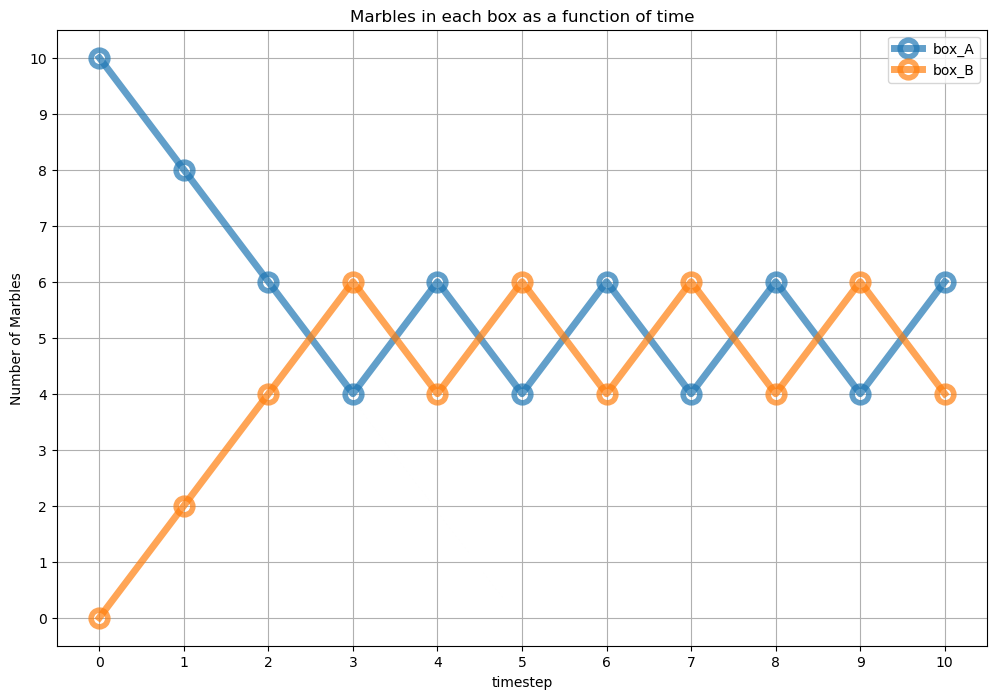

In [16]:
# Create figure
df = pd.DataFrame(system_events)
fig = df.plot(x='timestep', y=['box_A','box_B'], marker='o', markersize=12,
                markeredgewidth=4, alpha=0.7, markerfacecolor='black',
                linewidth=5, figsize=(12,8),  title="Marbles in each box as a function of time", 
                ylabel='Number of Marbles', grid=True, fillstyle='none',  
                xticks=list(df['timestep'].drop_duplicates()),
                yticks=list(range(1+(df['box_A']+df['box_B']).max())));

Because we have made it so that both robots read and update the state of the system at the same time, the equilibrium we had before (with 5 marbles in each box) is never reached. Instead, the system oscillates around that point.

---

_About BlockScience_  
[BlockScience](http://bit.ly/github_articles_M_02) is a research and engineering firm specialized in complex adaptive systems and applying practical methodologies from engineering design, development and testing to projects in emerging technologies such as blockchain. Follow us on [Medium](http://bit.ly/bsci-medium) or [Twitter](http://bit.ly/bsci-twitter) to stay in touch.